## Hierarchical Text Categorization using Watson NLP - Fine Tune (PubMed dataset)

### Use Case 
Hierarchical text categorization provides a more structured and organized approach to categorizing text, enabling better analysis, improved search, and more efficient content management. So Creating a hierarchical categorization system for public medical dataset that is more specific than broad categories like Humanities, Health Care, Anatomy, Phenomena and Processes, Named Groups, Geographicals, Technology, Industry, and Agriculture, Chemicals and Drugs, Anthropology, Education, Sociology, and Social Phenomena, Information Science, Disciplines and Occupations, Analytical, Diagnostic and Therapeutic Techniques, and Equipment, Diseases, Psychiatry and Psychology, and Organisms. 

This notebook demonstrates how to use the Explicit Semantic Analysis (ESA) block for performing text categorization. This model has been pre-trained on scrapped web data & news data set.

The dataset contains over 50000 medical data with categories. The original source of this dataset is from [Kaggle](https://www.kaggle.com/datasets/owaiskhan9654/pubmed-multilabel-text-classification)

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). The syntax block performs NLP primitive tasks on the input text. It uses Izumo, the standard NLP primitives component of Watson NLP to perform the following tasks:
    1. Sentence detection
    1. Tokenization: can't -> ca + n't
    1. Part-of-Speech tagging: I thought -> I/PRON, thought/VERB
    1. Lemmatization: I thought -> I/I, thought/think
    1. Dependency parsing: I -> nsubj -> thought -> root
    
- **ESA Hierarchical Algorithm** The ESA Hierarchical Algorithm provides a data-free method for hierarchical text categorization. Instead of relying on training data, each label is equipped with a collection of key phrases, represented as n-grams, that are meant to define the semantic scope associated with that label. These key phrases can then be used to obtain an ESA concept vector for the label.

- **Hierarchical Text Categorization** with the ESAHierarchical (`categories_esa_en_stock`),categories block. This pre-train model is useful in Adtech usecases where webpages are categorized into a taxonomy of general domain topics, for advertisement placement and content recommendation. 
   


## Table of Contents

1. [Before you start](#beforeYouStart)
1. [Data Loading](#loadData)
1. [Data Processing & EDA](#EDA)
1. [Prepare Training data set](#training)
1. [Summary](#summary)

<a id="beforeYouStart"></a>
### 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime xx.x on Python 3.x_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson
!pip install watson_nlp

In [10]:
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [96]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [11]:
import json
import os
import pandas as pd

import watson_nlp

from watson_nlp.toolkit.categories import train_esa_utils
from watson_nlp.blocks.categories import ESAHierarchical
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400
import matplotlib.pyplot as plt
import numpy as np

In [12]:
pd.options.mode.chained_assignment = None

<a id="loadData"></a>
## 2. Data Loading (PubMed Dataset)

The dataset contains over 50000 medical data with categories. The original source of this dataset is from [Kaggle](https://www.kaggle.com/datasets/owaiskhan9654/pubmed-multilabel-text-classification)

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out Text Categorization on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

<span style="color:blueviolet"><strong>Step 2.1</strong> We load the medical dataset into a DataFrame.</span>

<span style="color:blue">This data set contains <strong>50000</strong> medical dataset with the ['Title', 'abstractText', 'meshMajor', 'pmid', 'meshid', 'meshroot', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z'].</span>

In [13]:
# load data set into a dataframe
file_name = "PubMed Multi Label Text Classification Dataset Processed.csv"
buffer = project.get_file(file_name)
med_df = pd.read_csv(buffer)


# preview the data set
med_df.head(5)

Title  \
0                                                               Expression of p53 and coexistence of HPV in premalignant lesions and in cervical cancer.   
1  Vitamin D status in pregnant Indian women across trimesters and different seasons and its correlation with neonatal serum 25-hydroxyvitamin D levels.   
2                                                       [Identification of a functionally important dipeptide in sequences of atypical opioid peptides].   
3                                                   Multilayer capsules: a promising microencapsulation system for transplantation of pancreatic islets.   
4                                                                         Nanohydrogel with N,N'-bis(acryloyl)cystine crosslinker for high drug loading.   

                                                                                                                                                                                                                                                                                                                                                                                                      abstractText  \
0  Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. Firstly, using mixed starters, chosen genomic DNA sequences were amplified; secondly the material thus obtained was analyzed by hybridization method using oligonucleotyde 31-P labelled probe. HPVs of type 6, 11, 1...   
1  The present cross-sectional study was conducted to determine the vitamin D status of pregnant Indian women and their breast-fed infants. Subjects were recruited from the Department of Obstetrics, Armed Forces Clinic and Army Hospital (Research and Referral), Delhi. A total of 541 apparently healthy women with uncomplicated, single, intra-uterine gestation reporting in any trimester were consec...   
2  The occurrence of individual amino acids and dipeptide fragments in the sequences of 60 known atypical opioid peptides was analyzed. An expressed predominance of Tyr-Pro fragment suggested a high probability of analgesic activity for this dipeptide, and it was experimentally studied. It was shown on somatic and visceral pain sensitivity models that, on the i.p. administration of Tyr-Pro at dos...   
3  In 1980, Lim and Sun introduced a microcapsule coated with an alginate/polylysine complex for encapsulation of pancreatic islets. Characteristic to this type of capsule is, that it consists of a plain membrane which is formed during a single procedural step. With such a simple process it is difficult to obtain instantly a membrane optimized with respect to all the properties requested for isle...   
4  Substantially improved hydrogel particles based on poly(N-isopropylacrylamide) (pNIPA) have been obtained. First, as a result of replacing commercially available N,N'-bis(acryloyl)cystamine (BAC), the crosslinker, with acryloyl derivative of cystine containing a carboxylic group (BISS), the hydrogel particles acquired improved stability vs. ionic strength and allowed further chemical modificat...   

                                                                                                                                                                                                                                                                                                                                                                                                         meshMajor  \
0                                                                                                                                                                                                                    ['DNA Probes, HPV', 'DNA, Viral', 'Female', 'Humans', 'Immunohistochemistry', 'Papillomaviridae', 'Tumor Suppressor Protein p53', 'Uterine Cervical Dyspla

<a id="EDA"></a>
## 3. Data Processing & EDA

<span style="color:blueviolet"> <strong>Step 3.1 <strong> Checking columns name from medical dataset</span>

In [14]:
len(med_df)

50000

In [15]:
# preview the data set
med_df.columns

Index(['Title', 'abstractText', 'meshMajor', 'pmid', 'meshid', 'meshroot', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z'],
      dtype='object')

In [16]:
med_df.abstractText[0]

'Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. Firstly, using mixed starters, chosen genomic DNA sequences were amplified; secondly the material thus obtained was analyzed by hybridization method using oligonucleotyde 31-P labelled probe. HPVs of type 6, 11, 16, 18, 33 were identified. The p-53 expression was assayed by immunohistochemical method. HPV infection was often associated with dysplasia and cervical cancer. In cervical cancer mainly HPV 16 and 18 with high oncogenic potential were found. The p-53 was present rarely, and in minute quantities. No correlation was observed between presence of p-53 and HPVs DNA.'

In [17]:
med_df.meshMajor[0]

"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'Humans', 'Immunohistochemistry', 'Papillomaviridae', 'Tumor Suppressor Protein p53', 'Uterine Cervical Dysplasia', 'Uterine Cervical Neoplasms']"

In [18]:
med_df.meshroot[0]

"['Chemicals and Drugs [D]', 'Organisms [B]', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]', 'Disciplines and Occupations [H]', 'Diseases [C]']"

In [19]:
med_df.meshMajor[1]

"['Adult', 'Alkaline Phosphatase', 'Breast Feeding', 'Cross-Sectional Studies', 'Female', 'Humans', 'India', 'Infant', 'Infant Nutrition Disorders', 'Lactation', 'Mothers', 'Nutritional Status', 'Parathyroid Hormone', 'Pregnancy', 'Pregnancy Complications', 'Pregnancy Trimesters', 'Seasons', 'Vitamin D', 'Vitamin D Deficiency', 'Vitamins', 'Young Adult']"

In [20]:
med_df.meshroot[1]

"['Named Groups [M]', 'Chemicals and Drugs [D]', 'Psychiatry and Psychology [F]', 'Phenomena and Processes [G]', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]', 'Health Care [N]', 'Organisms [B]', 'Geographicals [Z]', 'Diseases [C]', 'Anthropology, Education, Sociology, and Social Phenomena [I]', 'Technology, Industry, and Agriculture [J]']"

<span style="color:blueviolet"> <strong>Step 3.2 <strong> Preparing taraining dataset for text categorization</span>

In [21]:
### Training data for Text Categarization
med_training_df = med_df[['meshMajor','meshroot']]


In [22]:
med_training_df.head(30)

meshMajor  \
0                                                                                                                                                                                                                     ['DNA Probes, HPV', 'DNA, Viral', 'Female', 'Humans', 'Immunohistochemistry', 'Papillomaviridae', 'Tumor Suppressor Protein p53', 'Uterine Cervical Dysplasia', 'Uterine Cervical Neoplasms']   
1                                               ['Adult', 'Alkaline Phosphatase', 'Breast Feeding', 'Cross-Sectional Studies', 'Female', 'Humans', 'India', 'Infant', 'Infant Nutrition Disorders', 'Lactation', 'Mothers', 'Nutritional Status', 'Parathyroid Hormone', 'Pregnancy', 'Pregnancy Complications', 'Pregnancy Trimesters', 'Seasons', 'Vitamin D', 'Vitamin D Deficiency', 'Vitamins', 'Young Adult']   
2                                                                   ['Amino Acid Sequence', 'Analgesics, Opioid', 'Animals', 'Consensus Sequence', 'Dipeptides', 'Guinea Pigs', 'In Vitro Techniques', 'Male', 'Mice', 'Molecular Sequence Data', 'Muscle Contraction', 'Muscle, Smooth', 'Narcotic Antagonists', 'Opioid Peptides', 'Pain Measurement', 'Rats', 'Receptor, Cannabinoid, CB1', 'Receptors, Opioid']   
3   ['Acrylic Resins', 'Alginates', 'Animals', 'Biocompatible Materials', 'Biopolymers', 'Carboxymethylcellulose Sodium', 'Cells, Cultured', 'Compressive Strength', 'Drug Compounding', 'Female', 'Fibrosis', 'Glucuronic Acid', 'Hexuronic Acids', 'Islets of Langerhans Transplantation', 'Materials Testing', 'Microspheres', 'Muscle, Skeletal', 'Particle Size', 'Permeability', 'Polyethyleneimine', 'Pol...   
4                                                                                                                                                                                                    ['Antineoplastic Agents', 'Cell Proliferation', 'Cell Survival', 'Cross-Linking Reagents', 'Cystine', 'Doxorubicin', 'Drug Carriers', 'Drug Liberation', 'HeLa Cells', 'Humans', 'Hydrogels', 'Nanoparticles']   
5                                                                                                                                                                                                                                                                                                                                           ['Animal Distribution', 'Animals', 'Asia', 'Larva', 'Moths', 'Vietnam']   
6                                                                                                                                          ['Algorithms', 'Equipment Design', 'Equipment Failure Analysis', 'France', 'Internationality', 'Occupational Exposure', 'Power Plants', 'Radiation Dosage', 'Radiation Monitoring', 'Radiation Protection', 'Reproducibility of Results', 'Sensitivity and Specificity']   
7                                ['Adenoidectomy', 'Airway Extubation', 'Analgesics, Non-Narcotic', 'Analgesics, Opioid', 'Anesthetics, Inhalation', 'Bradycardia', 'Child', 'Child, Preschool', 'Dexmedetomidine', 'Emergence Delirium', 'Female', 'Humans', 'Hypotension', 'Male', 'Methyl Ethers', 'Pain Measurement', 'Pain, Postoperative', 'Prospective Studies', 'Sevoflurane', 'Tonsillectomy', 'Tramadol']   
8                                                                                                                                                                                                                             ['Adenosine Diphosphate', 'Adenosine Triphosphate', 'Animals', 'Electrophysiology', 'Guanosine Diphosphate', 'Magnesium', 'Mice', 'Muscles', 'Potassium Channels', 'Thionucleotides']   
9                                                                                                                                                                                                  ['Checklist', 'Civil Defense', 'Emergencies', 'Female', 'Humans', 'Male', 'Natural Disasters', 'Operating Rooms', 'Patient Care T

In [23]:
df_meshRoot = med_training_df['meshroot']

In [24]:
df_meshRoot.head()

0                                                                                                                                                                                                          ['Chemicals and Drugs [D]', 'Organisms [B]', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]', 'Disciplines and Occupations [H]', 'Diseases [C]']
1    ['Named Groups [M]', 'Chemicals and Drugs [D]', 'Psychiatry and Psychology [F]', 'Phenomena and Processes [G]', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]', 'Health Care [N]', 'Organisms [B]', 'Geographicals [Z]', 'Diseases [C]', 'Anthropology, Education, Sociology, and Social Phenomena [I]', 'Technology, Industry, and Agriculture [J]']
2                                                                                                                                                                                    ['Phenomena and Processes [G]', 'Information Science [L]', 'Chemicals and Dru

<span style="color:blueviolet"> <strong>Step 3.3 <strong> Creating unique categories values from dataset using meshRoot column</span>

In [25]:
# extarct message data through the channel name 
import re  
def extarct_dictionary_list(df_meshRoot):
    dictionary_list = set()
    for val in df_meshRoot:
        #print("original ----",len(val))
        val_data = val.split("',")
        #print("After split---",len(val_data))
        for val_value in val_data:
            val_value = val_value.replace("'","")
            for i in range(65,91):
                val_value = re.sub("\\["+chr(i)+"\\]", "", val_value)
            val_value= val_value.replace("[","").replace("]","")
            dictionary_list.add(val_value.strip())
    return dictionary_list

In [26]:
dictionary_list =extarct_dictionary_list(df_meshRoot)
print("final---",len(dictionary_list))
print("final---",dictionary_list)

final--- 16
final--- {'', 'Disciplines and Occupations', 'Organisms', 'Technology, Industry, and Agriculture', 'Chemicals and Drugs', 'Geographicals', 'Named Groups', 'Humanities', 'Diseases', 'Phenomena and Processes', 'Health Care', 'Anthropology, Education, Sociology, and Social Phenomena', 'Anatomy', 'Information Science', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment', 'Psychiatry and Psychology'}


In [27]:
len(dictionary_list)

16

In [28]:
dict_list =list(dictionary_list)

<span style="color:blueviolet"> <strong>Step 3.4 <strong>Removed blank category from categories list</span>

In [29]:
del dict_list[0]
print(dict_list)

['Disciplines and Occupations', 'Organisms', 'Technology, Industry, and Agriculture', 'Chemicals and Drugs', 'Geographicals', 'Named Groups', 'Humanities', 'Diseases', 'Phenomena and Processes', 'Health Care', 'Anthropology, Education, Sociology, and Social Phenomena', 'Anatomy', 'Information Science', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment', 'Psychiatry and Psychology']


<span style="color:blueviolet"> <strong>Step 3.5 <strong> Unique categories from public medical dataset</span>

In [30]:
print(len(dict_list))

15


<a id="training"></a>
## 4. Prepare Training data set

<span style="color:blueviolet"> <strong>Step 4.1 <strong> Creating training data set using unique dict values with meshMajor</span>

In [31]:
training_data=[]
for dict_val in dict_list:
    x_out =med_df['meshroot'].str.contains(dict_val)
    top_doc_list =set()
    for i in range(len(x_out)):
        if x_out[i] == True:
            mesh_value = med_df['meshMajor'][i]
            mesh_val_list = mesh_value.split("',")
            for mesh in mesh_val_list:top_doc_list.add(mesh.replace("[","").replace("]","").replace("'","").strip())
    training_data.append({'labels':[dict_val],'key_phrases':list(top_doc_list)})
    

In [32]:
print(len(training_data))

15


<span style="color:blueviolet"> <strong>Step 4.2 <strong> Sample Training data</span>

In [33]:
print(training_data[0])

{'labels': ['Disciplines and Occupations'], 'key_phrases': ['Corpus Callosum', 'Colchicine', 'Breast Implants', 'Photic Stimulation', 'Nitrobacter', 'Hemorrhage', 'Receptors, LDL', 'Receptor, TIE-2', 'Glycated Hemoglobin A', 'Meiosis', 'User-Computer Interface', 'Aortic Aneurysm', 'Coccidioidomycosis', 'Homosexuality, Female', 'Insurance, Health, Reimbursement', 'Hearing Loss', 'Receptors, Somatostatin', 'Chalcogens', 'Internal Fixators', 'Passive Cutaneous Anaphylaxis', 'Colitis', 'Legionella pneumophila', 'Cyclin D2', 'Disabled Children', 'Survival Rate', '"Practice Patterns, Physicians", Subtraction Technique', 'Hypocalcemia', 'Psychotria', 'Metabolome', 'Cushing Syndrome', 'Sputum', 'Calcineurin', 'Quantitative Trait Loci', 'Immunoglobulins', 'G(M1) Ganglioside', 'Massachusetts', 'Mass Screening', 'Epithelium, Corneal', 'Licensure, Nursing', 'Anticoagulants', 'Cystocele', 'Food Industry', 'Renin', 'Ear, External', 'Mass Behavior', 'Everolimus', 'Triage', 'Sexually Transmitted Disea

In [34]:
data_path = './categories_train_data.json'

<span style="color:blueviolet"> <strong>Step 4.3 <strong> Dumping training data into required json format</span>

In [35]:
def prepare_stream_from_python_list(data, syntax_model, data_path):
    '''Given a Python data object, dump it to disk as a JSON file, then use that
    to initialize a new training stream. Note that the data stream is lazily
    initialized; the file at data_path needs to exist when we re-enter the data stream,
    since we don't want to load the whole thing into memory.

    Args:
        data: list(dict)
            ESA Categories training data.
        syntax_model: watson_nlp.blocks.syntax.izumo.IzumoTextProcessing
            Syntax model to be used to tokenize training texts.
        data_path: str
            Location to which we want to save our training data.
    Returns:
        watson_core.data_model.streams.data_stream.DataStream
            DataStream to be passed to ESA train.
    '''
    # Dump the Python object to a JSON file
    with open(data_path, 'w', encoding='utf-8') as f:
        json.dump(data, f)
    # Prepare traininig data from a JSON file
    return train_esa_utils.prepare_data_from_json(data_path, syntax_model)

<span style="color:blueviolet"> <strong>Step 4.4 <strong> Downloading required specific models for training data</span>

In [36]:
# Prepare the Categories DataStream
print('Downloading existing Syntax / Categories models...')
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
# Download an existing categories model; note that we are not loading this into memory, just downloading it.
categories_model_path = watson_nlp.download('categories_esa_en_stock')


<a id="MB"></a>
## 5. Model Building

<span style="color:blueviolet"> <strong>Step 5.1 <strong> Training the model using ESAHierarchical.train method</span>

In [100]:
print('Training the model...')
print('Training the model...')
print('Training the model...')
train_data_stream = prepare_stream_from_python_list(training_data, syntax_model, data_path)
model = ESAHierarchical.train(train_data_stream, categories_model_path)
print('[DONE]')
print('[DONE]')

Training the model...
Training the model...
[DONE]


<span style="color:blueviolet"> <strong>Step 5.2 <strong> Saving the model</span>

In [103]:
model.save('pub_med_categories_model')
project.save_data('pub_med_categories_model', data=model.as_file_like_object(), overwrite=True)

{'file_name': 'pub_med_categories_model',
 'message': 'File saved to project storage.',
 'bucket_name': 'watsoncore-donotdelete-pr-olkxvfa8bk0pb1',
 'asset_id': '52b9f710-ee62-4795-8bde-44cf9c48f12d'}

<span style="color:blueviolet"> <strong>Step 5.3 <strong> Loading and testing the model</span>


In [104]:
med_df

Title  \
0                                                                   Expression of p53 and coexistence of HPV in premalignant lesions and in cervical cancer.   
1      Vitamin D status in pregnant Indian women across trimesters and different seasons and its correlation with neonatal serum 25-hydroxyvitamin D levels.   
2                                                           [Identification of a functionally important dipeptide in sequences of atypical opioid peptides].   
3                                                       Multilayer capsules: a promising microencapsulation system for transplantation of pancreatic islets.   
4                                                                             Nanohydrogel with N,N'-bis(acryloyl)cystine crosslinker for high drug loading.   
...                                                                                                                                                      ...   
49995                       Five donors-one recipient: modeling a mosaic of granulocytes, natural killer and T cells from cord-blood and third-party donors.   
49996                                                                                     The role of eicosanoids in cyclosporine nephrotoxicity in the rat.   
49997                                                 Impact of pancreaticoduodenal arcade dilation on postoperative outcomes after pancreaticoduodenectomy.   
49998                                                     Outcomes of Preterm Infants following Discussions about Withdrawal or Withholding of Life Support.   
49999                                         Molecular subtyping of Borrelia burgdorferi sensu lato isolates from five patients with solitary lymphocytoma.   

                                                                                                                                                                                                                                                                                                                                                                                                          abstractText  \
0      Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. Firstly, using mixed starters, chosen genomic DNA sequences were amplified; secondly the material thus obtained was analyzed by hybridization method using oligonucleotyde 31-P labelled probe. HPVs of type 6, 11, 1...   
1      The present cross-sectional study was conducted to determine the vitamin D status of pregnant Indian women and their breast-fed infants. Subjects were recruited from the Department of Obstetrics, Armed Forces Clinic and Army Hospital (Research and Referral), Delhi. A total of 541 apparently healthy women with uncomplicated, single, intra-uterine gestation reporting in any trimester were consec...   
2      The occurrence of individual amino acids and dipeptide fragments in the sequences of 60 known atypical opioid peptides was analyzed. An expressed predominance of Tyr-Pro fragment suggested a high probability of analgesic activity for this dipeptide, and it was experimentally studied. It was shown on somatic and visceral pain sensitivity models that, on the i.p. administration of Tyr-Pro at dos...   
3      In 1980, Lim and Sun introduced a microcapsule coated with an alginate/polylysine complex for encapsulation of pancreatic islets. Characteristic to this type of capsule is, that it consists of a plain membrane which is formed during a single procedural step. With such a simple process it is difficult to obtain instantly a membrane optimized with respect to all the properties requested for isle...   
4      Substantially improved hydrogel particles based on poly(N-isopropylacrylamide) (pNIPA) have been obtained. First, as a result of replacing commercially available N,N'-bis(ac

In [105]:
med_df.meshroot[0]

"['Chemicals and Drugs [D]', 'Organisms [B]', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]', 'Disciplines and Occupations [H]', 'Diseases [C]']"

In [106]:
# Run syntax on text
text =med_df.abstractText[0]
syntax_result = syntax_model.run(text)
results = model.run(syntax_result)

results.categories

[{
   "labels": [
     "Humanities"
   ],
   "score": 0.574879,
   "explanation": []
 },
 {
   "labels": [
     "Anthropology, Education, Sociology, and Social Phenomena"
   ],
   "score": 0.521256,
   "explanation": []
 },
 {
   "labels": [
     "Chemicals and Drugs"
   ],
   "score": 0.502489,
   "explanation": []
 }]

<span style="color:blueviolet"> <strong>Step 5.4 Running categories model over the 1000 medical data to predict categories

In [107]:
def get_categories_prediction(text):
    syntax_data = syntax_model.run(text)
    categories_prediction = model.run(syntax_data, explanation=True)
    return {'categories_prediction':categories_prediction }

In [108]:
categories_prediction_data = [get_categories_prediction(doc) for doc in med_df.abstractText[0:1000]]

<span style="color:blue"> Categorization model output shows labels of categories with the score and explanation </span>

In [109]:
# extarcting the all categories
categories_prediction_list =[]
for value in categories_prediction_data:
    if len(value['categories_prediction'].categories)==0:
        categories_prediction_list.append([])
    else:
        categories_prediction_list.append(value['categories_prediction'].categories[0].labels)

# creating a dict for short_description & categories

categories_prediction_dict ={'short_description':med_df['Title'][0:1000],'categories_prediction':categories_prediction_list}
categories_prediction_df = pd.DataFrame(categories_prediction_dict) 

In [110]:
categories_prediction_df.head(20)

short_description  \
0                                                                                                         Expression of p53 and coexistence of HPV in premalignant lesions and in cervical cancer.   
1                                            Vitamin D status in pregnant Indian women across trimesters and different seasons and its correlation with neonatal serum 25-hydroxyvitamin D levels.   
2                                                                                                 [Identification of a functionally important dipeptide in sequences of atypical opioid peptides].   
3                                                                                             Multilayer capsules: a promising microencapsulation system for transplantation of pancreatic islets.   
4                                                                                                                   Nanohydrogel with N,N'-bis(acryloyl)cystine crosslinker for high drug loading.   
5                                                                                                   A new <i>Panolis</i> H?bner, [1821] species from Vietnam (Lepidoptera, Noctuidae, Orthosiini).   
6                                                                                                                                            Characterization of neutron field in a NPP workplace.   
7   Tramadol vs dexmedetomidine for emergence agitation control in pediatric patients undergoing adenotonsillectomy with sevoflurane anesthesia: prospective randomized controlled clinical study.   
8                                                                                                   Nucleotide diphosphates activate the ATP-sensitive potassium channel in mouse skeletal muscle.   
9                               Using Standardized Checklists Increase the Completion Rate of Critical Actions in an Evacuation from the Operating Room: A Randomized Controlled Simulation Study.   
10                                                                           Tolerability of the low-affinity, use-dependent NMDA antagonist AR-R15896AR in stroke patients: a dose-ranging study.   
11                                                                                                                     Spatial distribution of external and internal intercostal activity in dogs.   
12                                                                                                             Dysbiosis of the Gut Microbiome is associated with Tumor Biomarkers in Lung Cancer.   
13                                                                                                                             Male Urethral Stricture: American Urological Association Guideline.   
14                                                                                                 Radiobiologic risk estimation from dental radiology. Part I. Absorbed doses to critical organs.   
15                                                           Massive Chondroblastoma of the Talus: Treatment With En Bloc Talectomy and Tibiocalcaneal Arthrodesis: Long-Term Follow-up of a Case.   
16                                                                                     Alternative pathways of apoptosis induced by methylprednisolone and valinomycin analyzed by flow cytometry.   
17                                                                                                      Methotrexate leukoencephalopathy presenting as Kl?ver-Bucy syndrome and uncinate seizures.   
18                                                                                                   Influence of genetic variation in alcohol and aldehyde dehydrogenase on serotonin metabolism.   
19                          Maternal and neonatal red blood cell n-3 polyunsaturated fatty acids inversely associate with infant whole-body fat mass assessed by dual-energy X-ray absorptiometry.   

                  

<span style="color:blue"> We are able to see more categories regarding the Medical data like Humanities, Technology, Industry, and Agriculture </span>

<span style="color:blueviolet"> <strong>Step 5.5 Analysis on news category data

In [111]:
# Convert values to strings
categories_prediction_df['categories_prediction'] = categories_prediction_df['categories_prediction'].astype(str)

# Split the values and remove "and"
categories_prediction_df['categories_prediction'] = categories_prediction_df['categories_prediction'].str.replace(" and|'", '').str.split(',')

# Strip whitespace and remove square brackets
categories_prediction_df['categories_prediction'] = categories_prediction_df['categories_prediction'].apply(lambda x: [item.strip(' []') for item in x])

# Explode the column to separate the values into multiple rows
categories_prediction_df = categories_prediction_df.explode('categories_prediction')


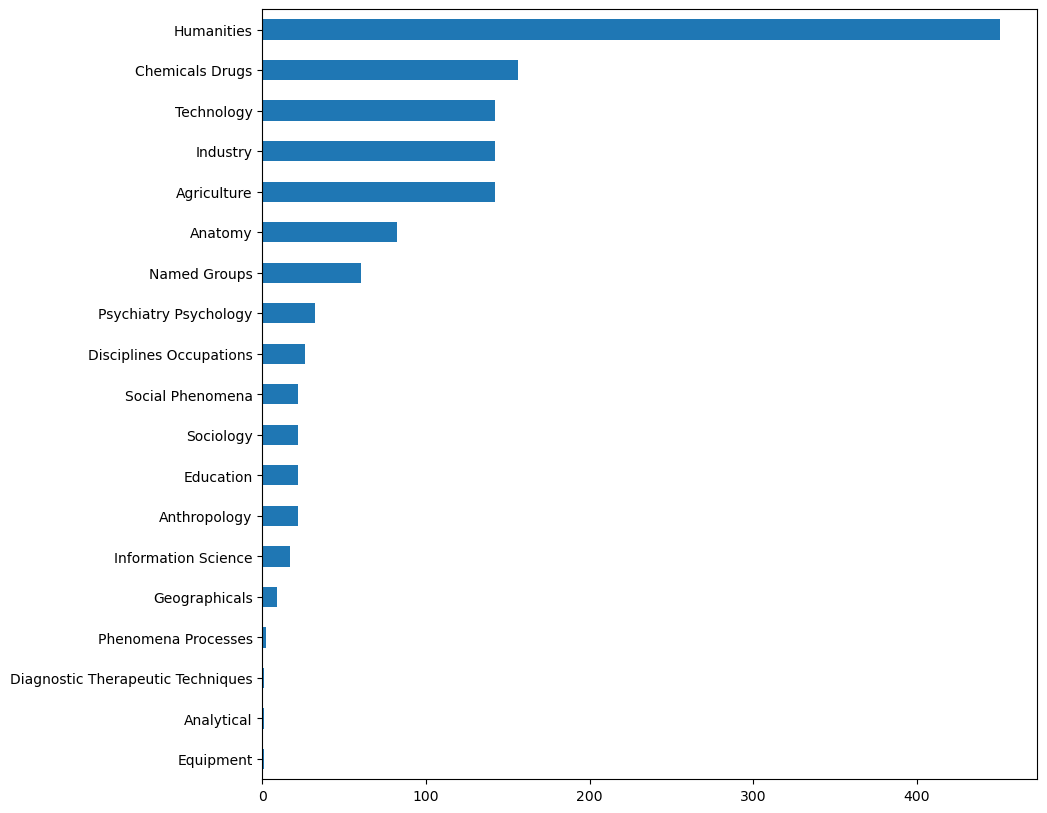

In [112]:
categories_prediction_df['categories_prediction'].value_counts().head(20).sort_values().plot(kind='barh',figsize=(10,10)) 

plt.show()

top categories detected by the fine-tune model is Humanities, Chemicals Drugs, technology, Industry, Agriculture 

<a id="summary"></a>
## 5. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library to:
1. Extract tokens, Parts of Speech, Lemmas etc
1. Extract Keywords and phrases from a text corpus
1. Extract Text Categories from a text corpus to understand what people are talking about.
    
</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2023 IBM Corporation 